<br/>

$$ \huge{\underline{\textbf{ Playing Atari Games with Deep RL }}} $$

$$ \large{\textbf{MountainCar + DQN + Memory Reply}} $$

<br/>



In [94]:
def q_learning(env, ep, gamma, eps_random_steps, eps_decay_steps, eps_target,
               batch_size, model, mem, callback=None, trace=None, max_tts=float('inf')):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        model      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, model, eps):
        if np.random.rand() > eps:
            q_values = model.eval(np.array([st]))
            return argmax_rand(q_values)
        else:
            return np.random.choice(env.act_space)
    
    if eps_decay_steps is not None:
        eps = 1
        eps_delta = (1-eps_target) / eps_decay_steps
    else:
        eps = eps_target
    
    tts_ = 0
    for e_ in range(ep):
        
        S = env.reset()
        
        for t_ in range(10**100):
            
            A = policy(S, model, eps)
            
            S_, R, done = env.step(A)
            
            mem.append(S, A, R, S_, done)
            
            if callback is not None:
                callback(e_, t_, S, A, R, done, eps, model, mem, trace)
            
            if tts_ > eps_random_steps:
                # new
                states, actions, rewards, n_states, dones, _ = mem.get_batch(batch_size)
                targets = model.eval(n_states)
                targets = rewards + gamma * np.max(targets, axis=-1)
                targets[dones] = 0   # value of terminal states is zero
                # targets = targets[range(len(targets)), actions]

                #if True in dones:
                #    pdb.set_trace()

                model.train(states, actions, targets)
                # ---
            
            
            
            # old train
#             if done:
#                 target = R
#             else:
#                 max_q = np.max(model.eval([S_]))
#                 target = R + gamma * max_q
#             model.train([S], [A], [target])
            # ---
            
            if done:
                break
                
            if tts_ > max_tts:
                return
                
            S = S_
            
            if tts_ > eps_random_steps:
                if eps > eps_target:
                    eps -= eps_delta
                    if eps < eps_target:
                        eps = eps_target

            tts_ += 1

In [9]:
def test_car(env, ep, model, callback=None, trace=None):

    def policy(st, model):
        q_values = model.eval([st])
        return argmax_rand(q_values)
    
    for e_ in range(ep):
        
        S = env.reset()
        
        
        for t_ in range(1000):       
        
            A = policy(S, model)
            S_, R, done = env.step(A)
            
            if callback is not None:
                if t_ == 999:  done=True
                callback(e_, t_, S, A, R, done, 0, model, None, trace)
            
            if done:
                break
                
            S = S_

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

Helper functions

In [10]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [11]:
def running_mean(x, n):
    res = []
    for i in range(len(x)):
#         print('i', i)
#         print('x[max(i-n+1, 0): i+1]', x[max(i-n+1, 0): i+1])
#         print('min(i+1, n)', min(i+1, n))
        
        res.append( sum(x[max(i-n+1, 0): i+1])   /   min(i+1, n) )
        
#         print('res', res)
        
#         print('--')
        
    return res

---

# Experiment Setup

Imports (source file: [tiles3.py](tiles3.py), [helpers_1001.py](helpers_1001.py))

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
from collections import OrderedDict
from mountain_car import MountainCarEnv
import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

Environment

In [13]:
env = MountainCarEnv()

Create function approximator and solve

# Run Experiments

We will need callback to capture q-value array for whole state-action space at specified episodes.

In [61]:
import pdb
from collections import OrderedDict

In [62]:
class EpisodeLog():
    def __init__(self, episode_nb):
        self.episode_nb = episode_nb
        self.total_tstep_finish = 0
        self.q_values = None
        self.states = []
        self.actions = []
        self.rewards = []  # t+1
        self.dones = []    # t+1
        
class Trace():
    def __init__(self):
        self.total_tstep = 0
        self.episodes = []
        self.epsilons = []
        self.q_values = OrderedDict()

In [95]:
def callback(episode, tstep, st, act, rew_, done_, eps, model, memory, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    
            
    if tstep == 0:
        trace.episodes.append(EpisodeLog(episode))
    
    trace.episodes[-1].total_tstep_finish = trace.total_tstep
    trace.episodes[-1].states.append(st)
    trace.episodes[-1].actions.append(act)
    trace.episodes[-1].rewards.append(rew_)
    trace.episodes[-1].dones.append(done_)
    
    trace.epsilons.append(eps)
    
    
    
    if done_:
        q_arr = eval_state_action_space(model, env)
        trace.episodes[-1].q_values = q_arr
        
    if trace.total_tstep % 1000 == 0:
        print('ep, ts, tts', episode, tstep, trace.total_tstep)
        
    if trace.total_tstep % 1000 == 0 and trace.total_tstep > 100000:
        q_arr = eval_state_action_space(model, env)
        trace.q_values[trace.total_tstep] = q_arr
        
        
        plot_mountain_car_2(env, episode, trace.total_tstep, q_arr,
                            trace.episodes[-1].states[-1000:], trace.episodes[-1].actions[-1000:])
    
    # if episode % 10 == 0 and tstep == 0:    
    #     print('.', end='')
        
    trace.total_tstep += 1

---

Plot

In [44]:
def experiment_tiles_single(ep, trace=None):
    if trace is None:
        trace = Trace()
    
    model = TileCodingFuncApprox(env.state_low, env.state_high, env.act_space,
                                 learn_rate=0.3, num_tilings=8, init_val=0)
    
    mem = Memory(max_len=1, state_shape=(2,), state_dtype=float)
    
    q_learning(env, ep=ep, gamma=1.0, eps_random_steps=0, eps_decay_steps=None, eps_target=0.0, batch_size=1,
               model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

In [45]:
def experiment_tiles_batch(ep, trace=None):
    if trace is None:
        trace = Trace()
    
    model = TileCodingFuncApprox(env.state_low, env.state_high, env.act_space,
                                 learn_rate=0.3, num_tilings=8, init_val=0)
    
    mem = Memory(max_len=10000, state_shape=(2,), state_dtype=float)
    
    q_learning(env, ep=ep, gamma=1.0, eps_random_steps=0, eps_decay_steps=None, eps_target=0.0, batch_size=64,
               model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

In [46]:
def plot_rewards(trace, label, color, alpha, axis):
    rewards = [sum(trace.episodes[i].rewards) for i in range(len(trace.episodes))]
    episodes = [trace.episodes[i].total_tstep_finish for i in range(len(trace.episodes))]
    rewards_avg = running_mean(rewards, 10)
    axis.scatter(episodes, rewards, color=color, alpha=alpha/2, label=label, marker='.')
    axis.plot(episodes, rewards_avg, color=color, alpha=alpha, label=label)
    return episodes, rewards

In [47]:
ts = time.time()
trace_t_s_1 = experiment_tiles_single(ep=100)
#trace_t_s_2 = experiment_tiles_single(ep=100)
#trace_t_s_3 = experiment_tiles_single(ep=100)
print('time', time.time()-ts)

..........
time 18.58895993232727


In [48]:
ts = time.time()
trace_t_b_1 = experiment_tiles_batch(ep=30)
#trace_t_b_2 = experiment_tiles_batch(ep=30)
#trace_t_b_3 = experiment_tiles_batch(ep=30)
print('time', time.time()-ts)

...
time 58.41236138343811


---

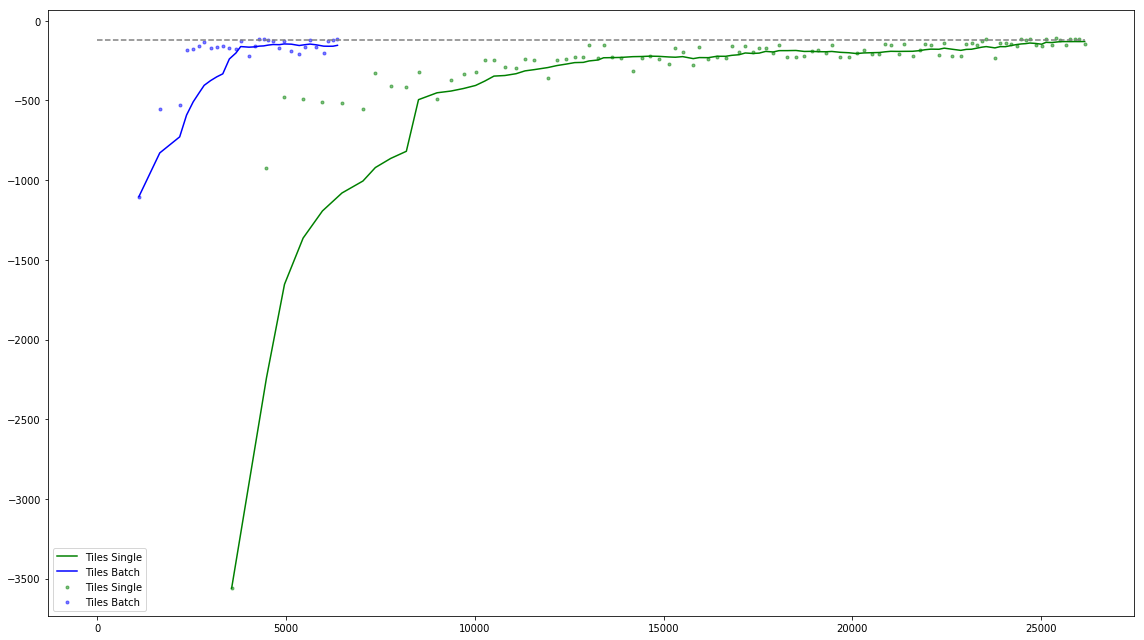

In [49]:
fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(111)

alpha = 1.

plot_rewards(trace_t_s_1, 'Tiles Single', color='green', alpha=alpha, axis=ax)
#plot_rewards(trace_t_s_2, '', color='green', alpha=alpha, axis=ax)
#plot_rewards(trace_t_s_3, '', color='green', alpha=alpha, axis=ax)

plot_rewards(trace_t_b_1, 'Tiles Batch', color='blue', alpha=alpha, axis=ax)
#plot_rewards(trace_t_b_2, '', color='blue', alpha=alpha, axis=ax)
#plot_rewards(trace_t_b_3, '', color='blue', alpha=alpha, axis=ax)

ax.plot([0, trace_t_s_1.total_tstep], [-120, -120], color='gray', linestyle='--')

plt.legend()
plt.tight_layout()
plt.show()

---

In [52]:
import tensorflow as tf

In [92]:
def experiment_keras(ep, max_tts, trace=None):
    if trace is None:
        trace = Trace()
    
    q_model = tf.keras.models.Sequential()
    q_model.add(tf.keras.layers.Dense(256, 'relu', input_dim=2))
    q_model.add(tf.keras.layers.Dense(256, 'relu'))
    q_model.add(tf.keras.layers.Dense(3, 'linear'))
    q_model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.00025))
    
    model = QFunctKeras(q_model, env.state_low, env.state_high, env.act_space)
    
#     model = TileCodingFuncApprox(env.state_low, env.state_high, env.act_space,
#                                  learn_rate=0.3, num_tilings=8, init_val=0)
    
    mem = Memory(max_len=100000, state_shape=(2,), state_dtype=float)
    
    q_learning(env, ep=ep, gamma=0.99, eps_random_steps=100000, eps_decay_steps=10000, eps_target=0.1, batch_size=1024,
               model=model, mem=mem, callback=callback, trace=trace, max_tts=max_tts)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

ep, ts, tts 0 0 0
ep, ts, tts 0 1000 1000
ep, ts, tts 0 2000 2000
ep, ts, tts 0 3000 3000
ep, ts, tts 0 4000 4000
ep, ts, tts 0 5000 5000
ep, ts, tts 0 6000 6000
ep, ts, tts 0 7000 7000
ep, ts, tts 0 8000 8000
ep, ts, tts 0 9000 9000
ep, ts, tts 0 10000 10000
ep, ts, tts 0 11000 11000
ep, ts, tts 0 12000 12000
ep, ts, tts 1 684 13000
ep, ts, tts 1 1684 14000
ep, ts, tts 1 2684 15000
ep, ts, tts 1 3684 16000
ep, ts, tts 1 4684 17000
ep, ts, tts 1 5684 18000
ep, ts, tts 1 6684 19000
ep, ts, tts 1 7684 20000
ep, ts, tts 1 8684 21000
ep, ts, tts 1 9684 22000
ep, ts, tts 1 10684 23000
ep, ts, tts 1 11684 24000
ep, ts, tts 1 12684 25000
ep, ts, tts 1 13684 26000
ep, ts, tts 1 14684 27000
ep, ts, tts 1 15684 28000
ep, ts, tts 1 16684 29000
ep, ts, tts 1 17684 30000
ep, ts, tts 1 18684 31000
ep, ts, tts 1 19684 32000
ep, ts, tts 1 20684 33000
ep, ts, tts 1 21684 34000
ep, ts, tts 1 22684 35000
ep, ts, tts 1 23684 36000
ep, ts, tts 1 24684 37000
ep, ts, tts 1 25684 38000
ep, ts, tts 2 268 39000

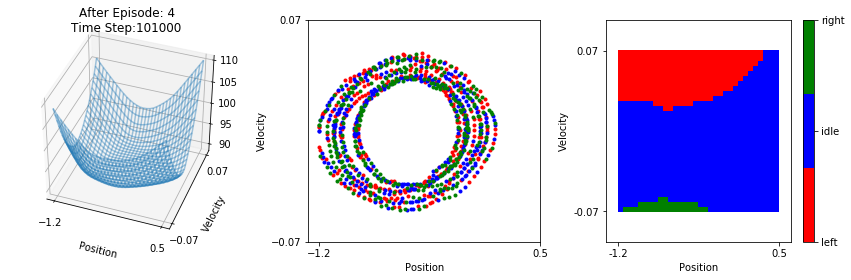

ep, ts, tts 4 18600 102000


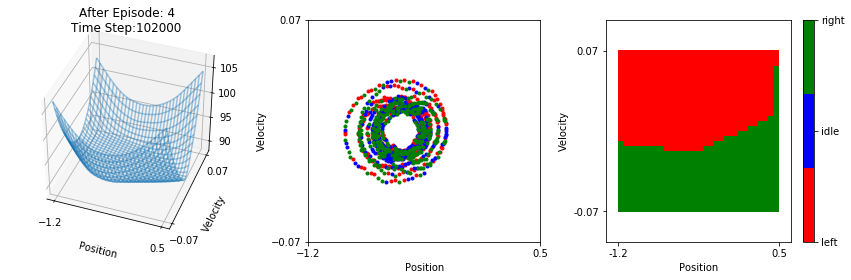

ep, ts, tts 4 19600 103000


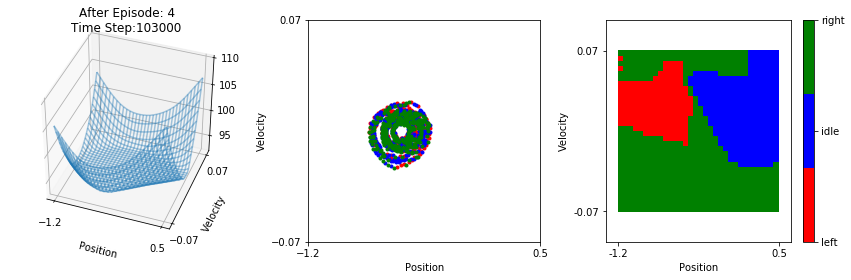

ep, ts, tts 4 20600 104000


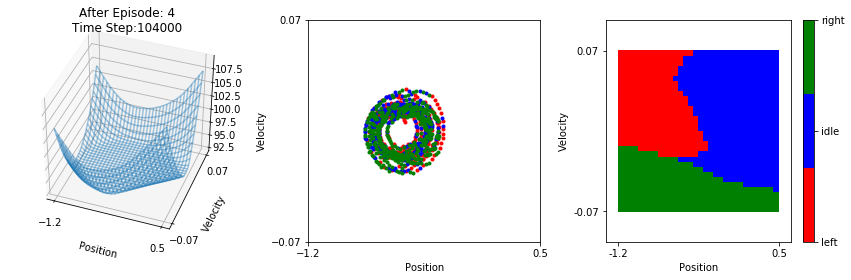

ep, ts, tts 4 21600 105000


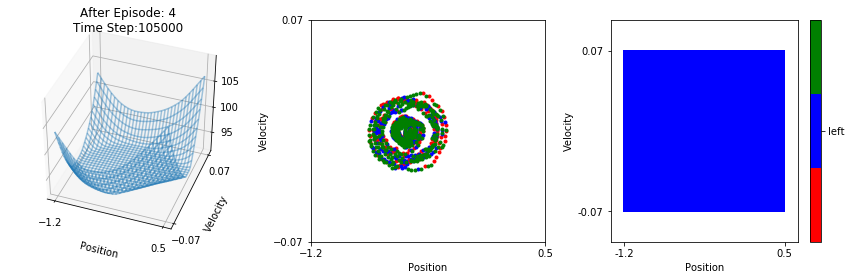

ep, ts, tts 4 22600 106000


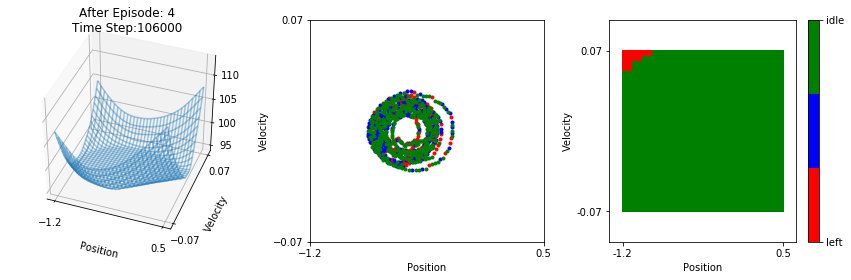

ep, ts, tts 4 23600 107000


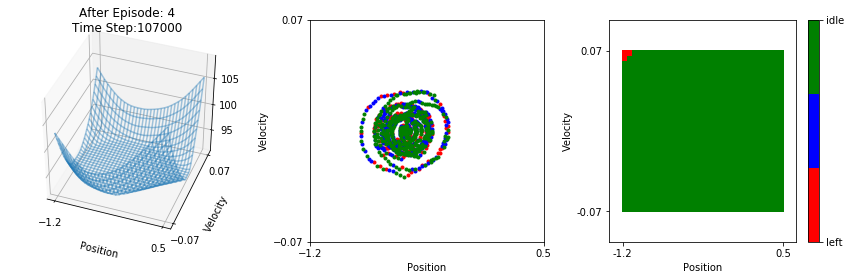

ep, ts, tts 4 24600 108000


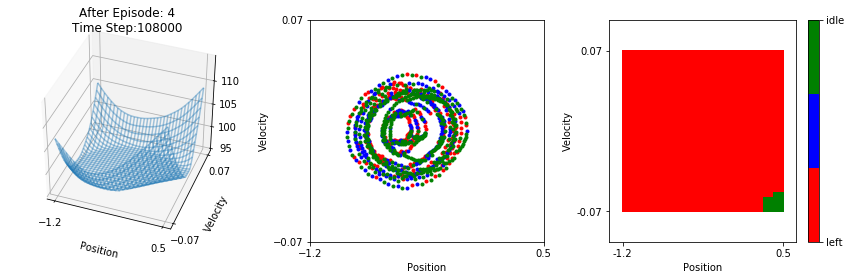

ep, ts, tts 4 25600 109000


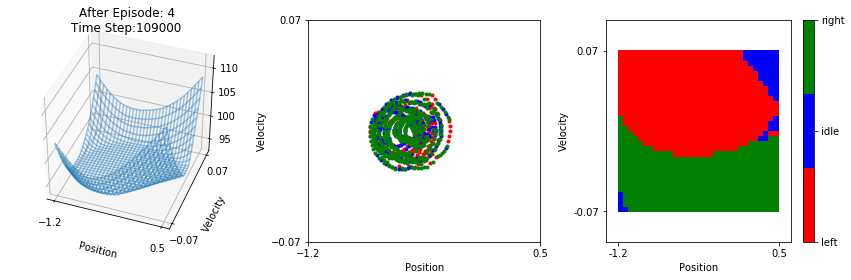

ep, ts, tts 4 26600 110000


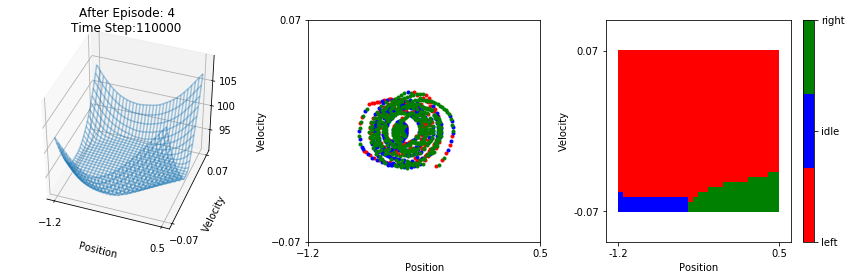

ep, ts, tts 4 27600 111000


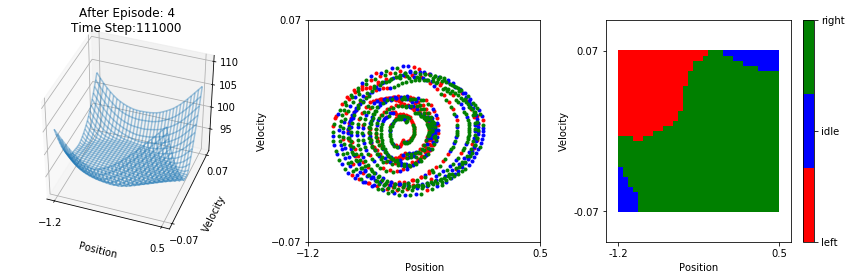

ep, ts, tts 4 28600 112000


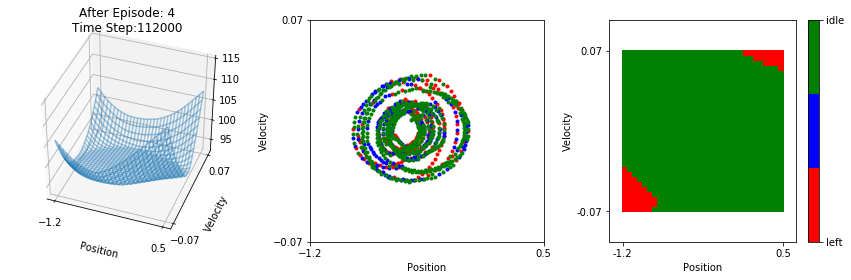

ep, ts, tts 4 29600 113000


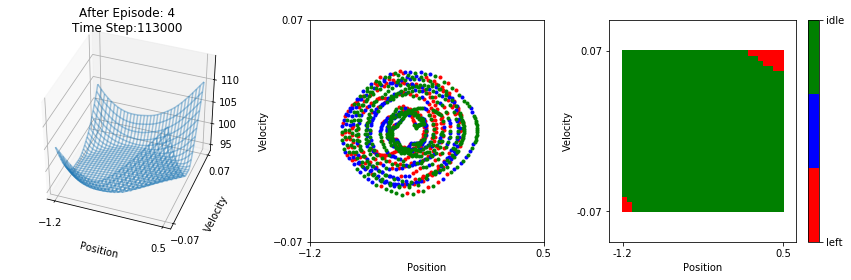

ep, ts, tts 4 30600 114000


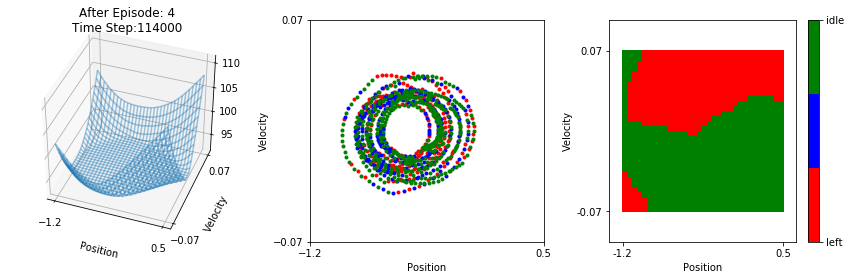

ep, ts, tts 4 31600 115000


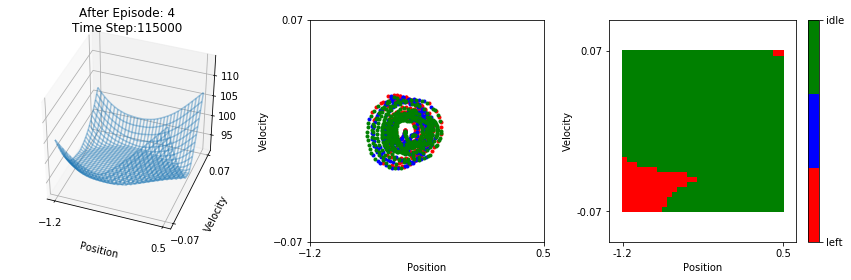

ep, ts, tts 4 32600 116000


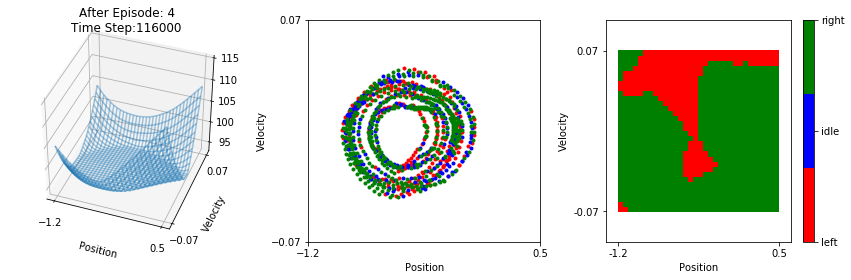

ep, ts, tts 5 384 117000


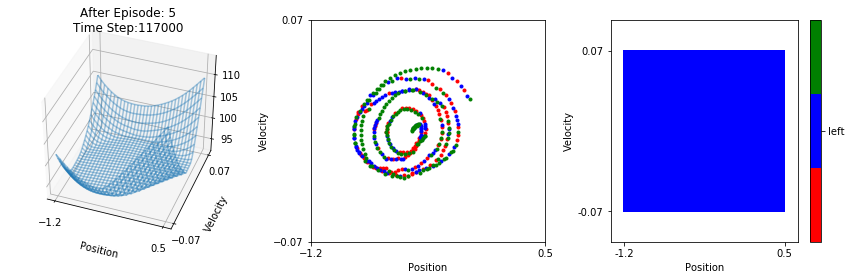

ep, ts, tts 6 350 118000


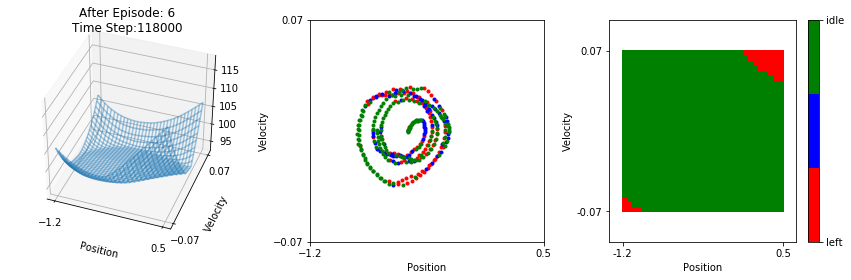

ep, ts, tts 7 53 119000


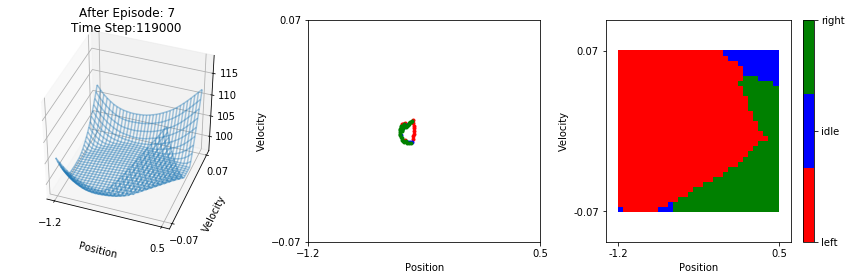

ep, ts, tts 8 385 120000


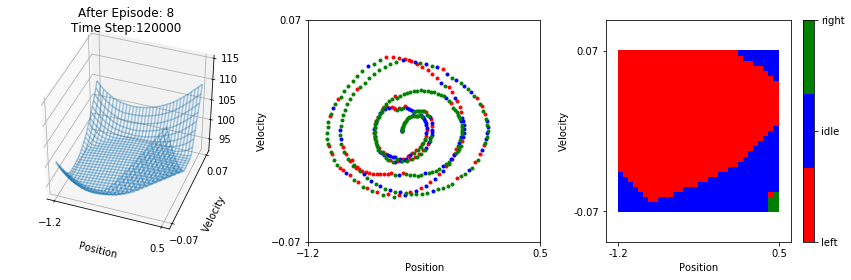

ep, ts, tts 11 55 121000


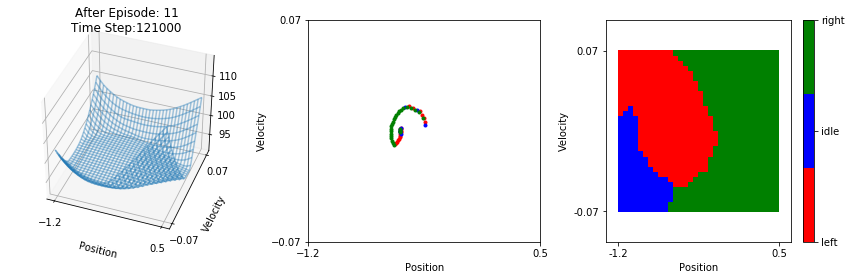

ep, ts, tts 13 68 122000


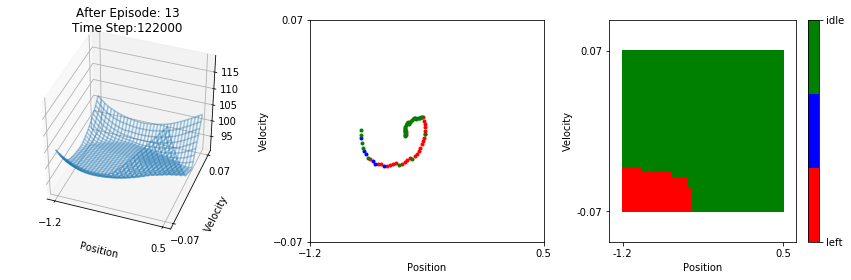

ep, ts, tts 16 169 123000


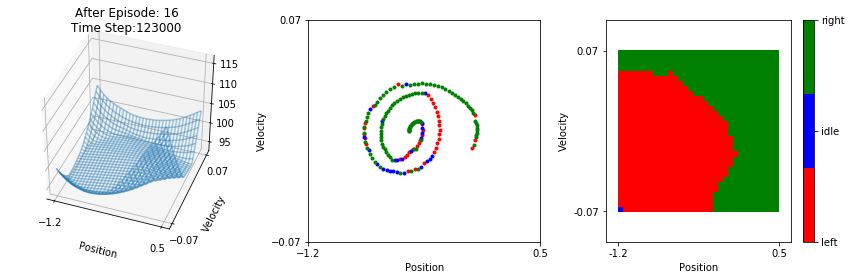

ep, ts, tts 19 272 124000


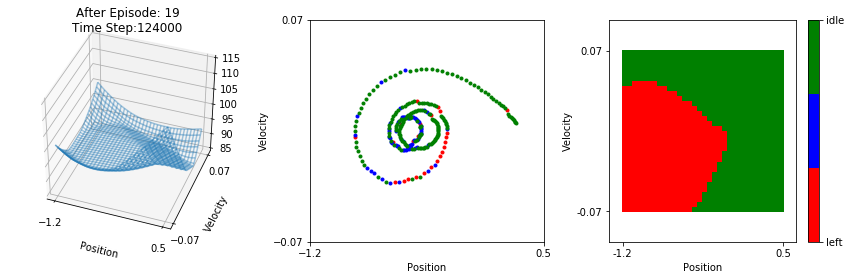

ep, ts, tts 21 505 125000


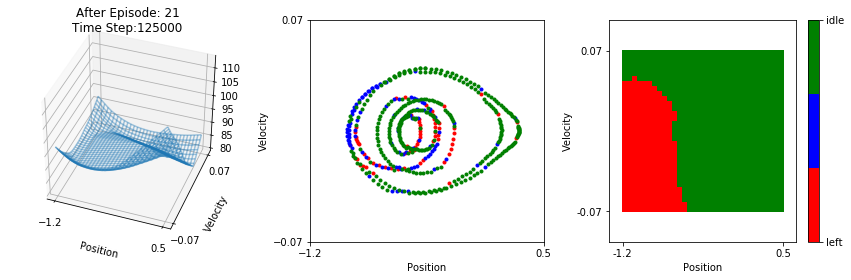

ep, ts, tts 26 145 126000


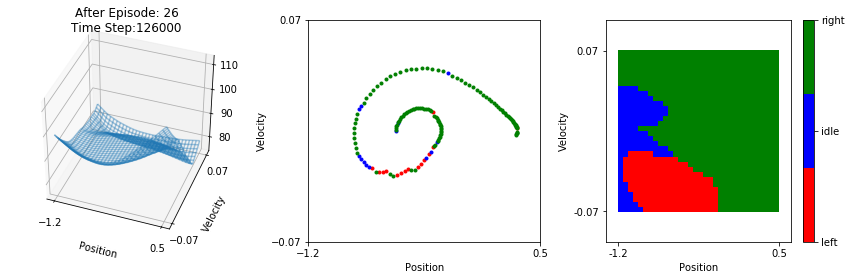

ep, ts, tts 31 57 127000


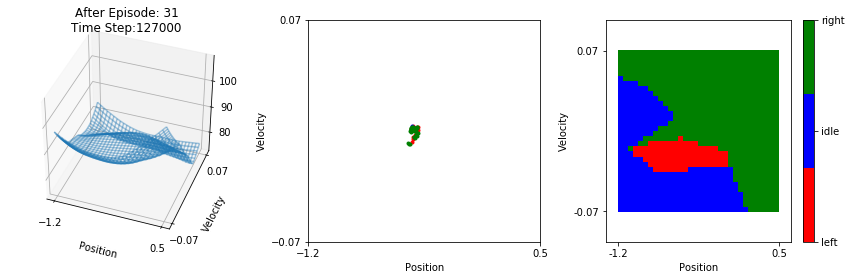

ep, ts, tts 35 139 128000


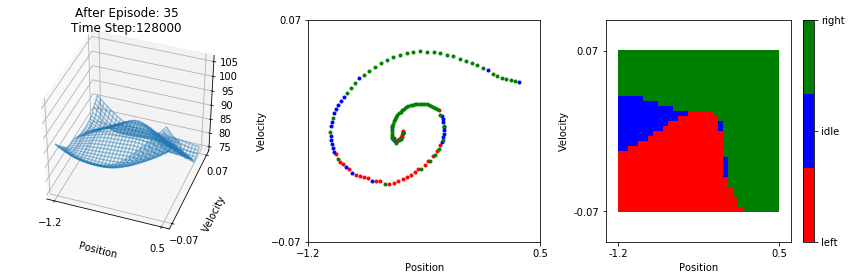

ep, ts, tts 40 264 129000


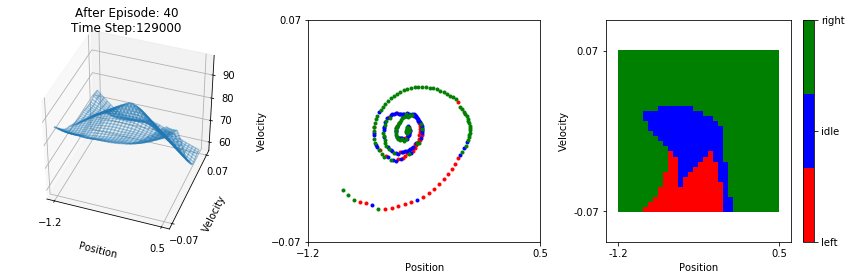

ep, ts, tts 45 86 130000


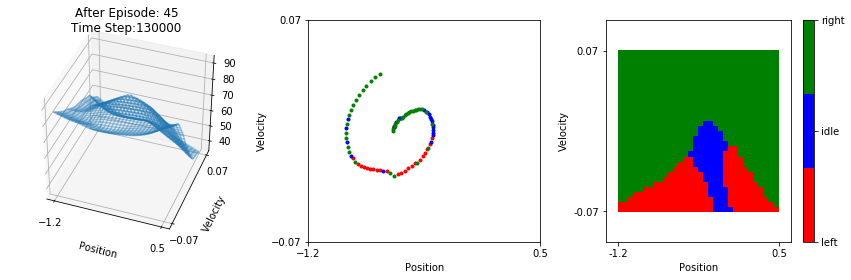

ep, ts, tts 51 193 131000


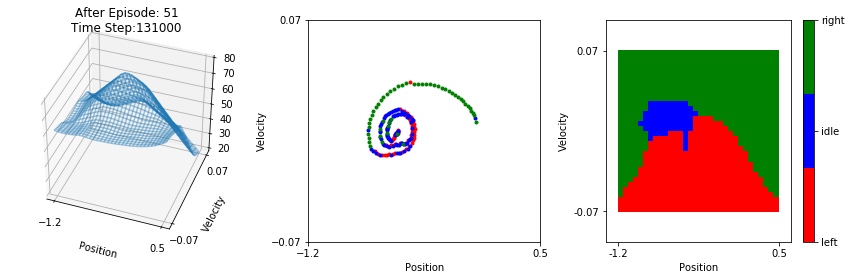

ep, ts, tts 57 86 132000


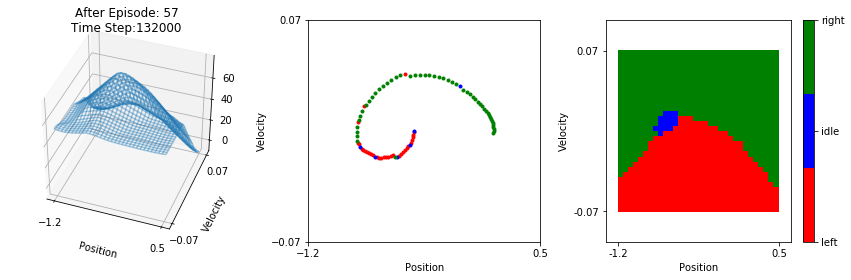

ep, ts, tts 63 93 133000


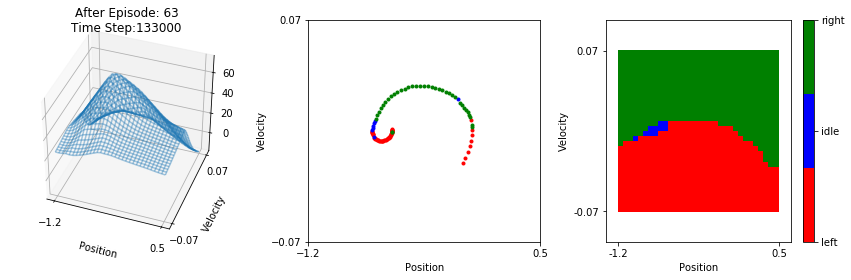

ep, ts, tts 70 79 134000


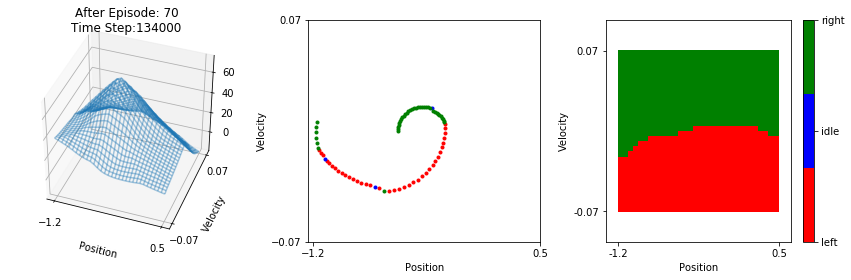

ep, ts, tts 77 152 135000


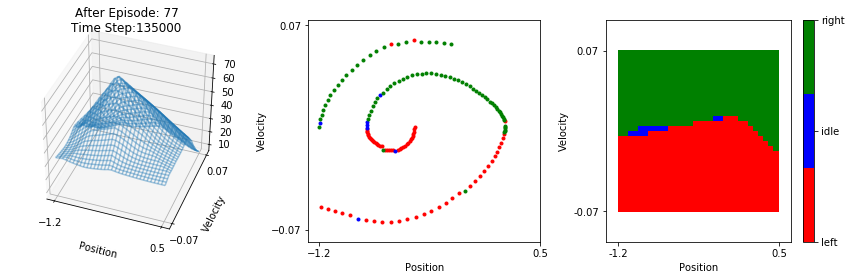

ep, ts, tts 85 37 136000


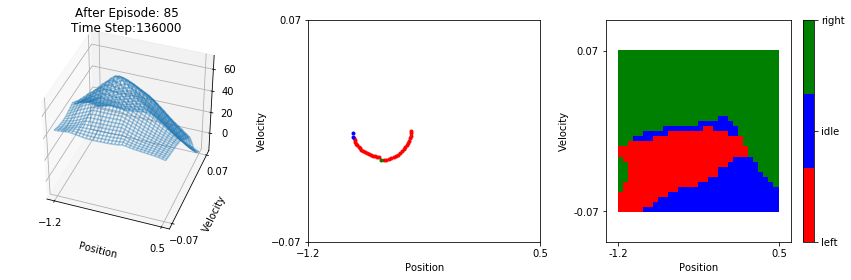

ep, ts, tts 92 9 137000


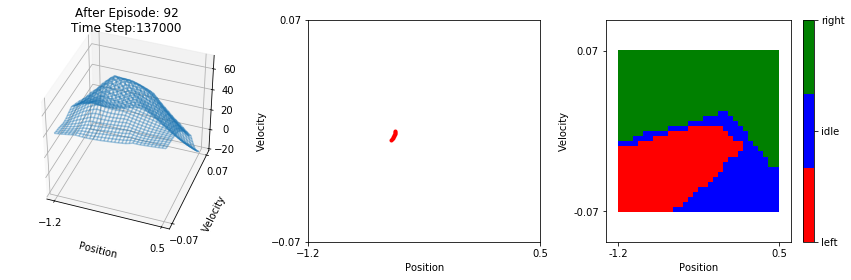

ep, ts, tts 99 24 138000


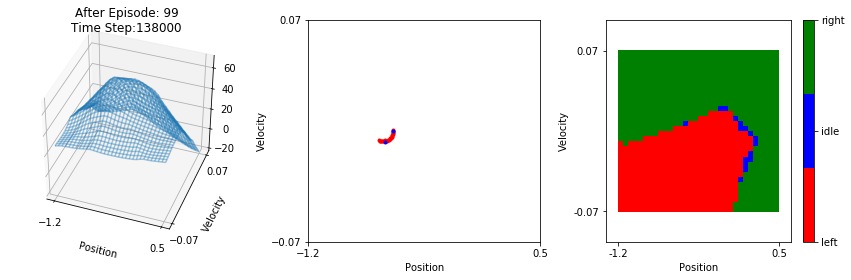

ep, ts, tts 106 45 139000


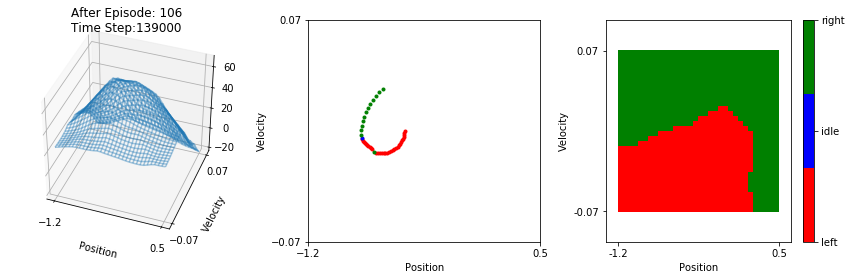

ep, ts, tts 113 5 140000


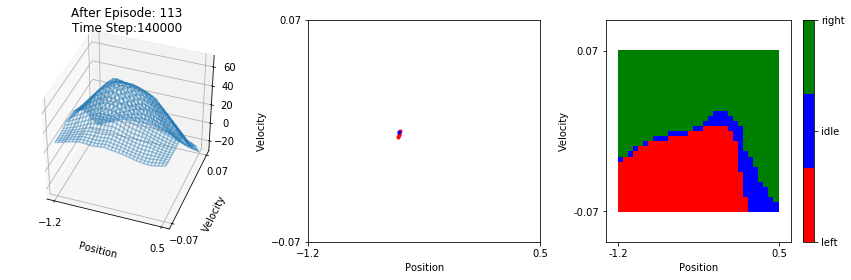

ep, ts, tts 119 148 141000


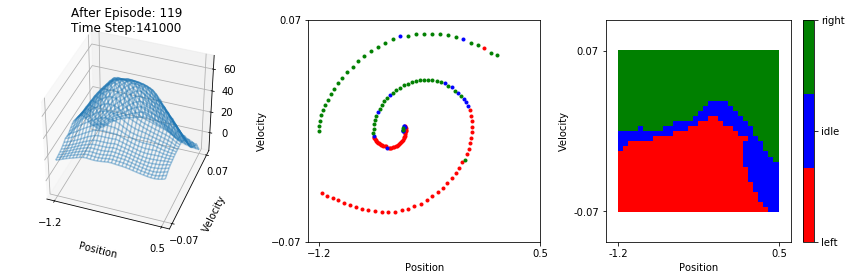

ep, ts, tts 127 4 142000


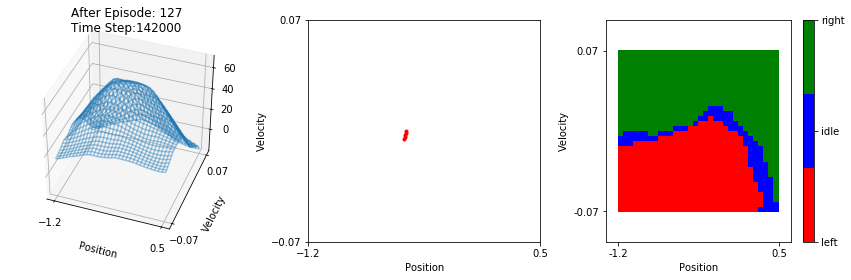

ep, ts, tts 134 14 143000


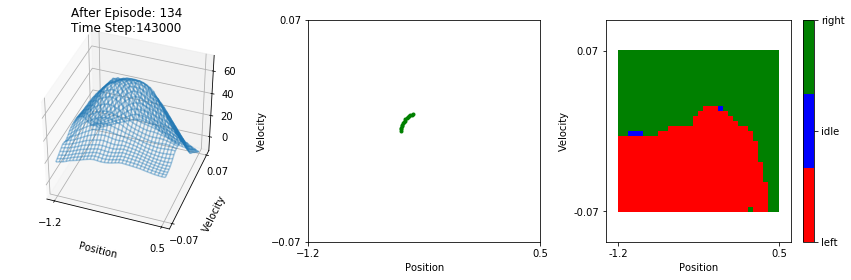

ep, ts, tts 141 96 144000


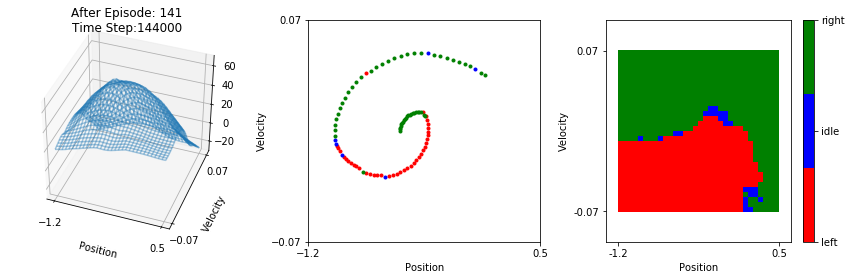

ep, ts, tts 150 33 145000


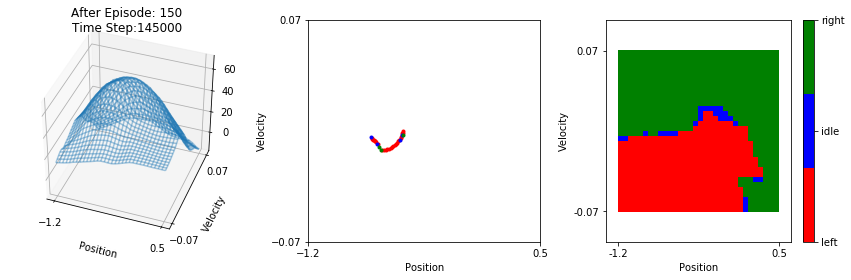

ep, ts, tts 157 111 146000


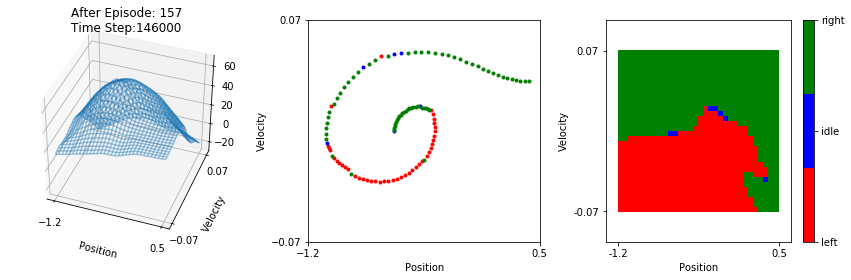

ep, ts, tts 166 62 147000


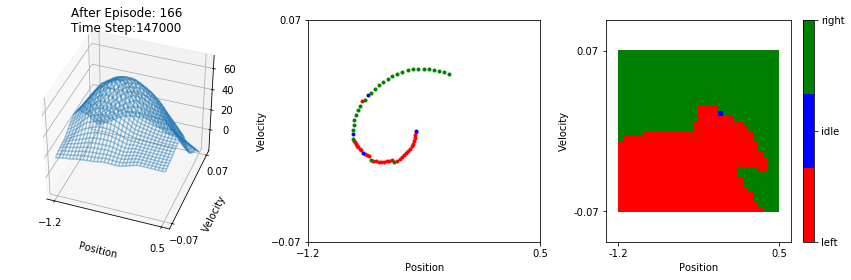

ep, ts, tts 174 22 148000


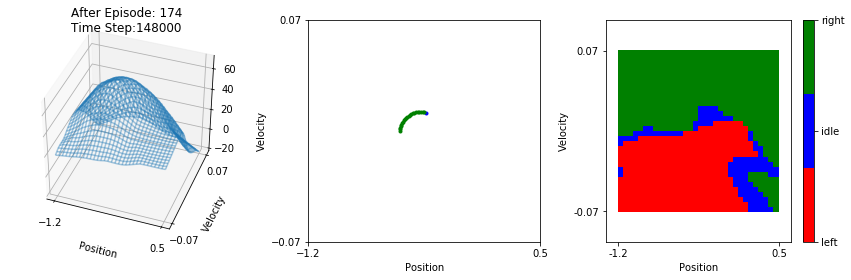

ep, ts, tts 182 102 149000


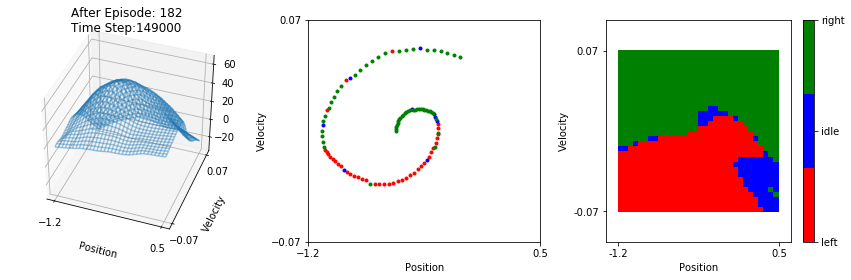

ep, ts, tts 192 10 150000


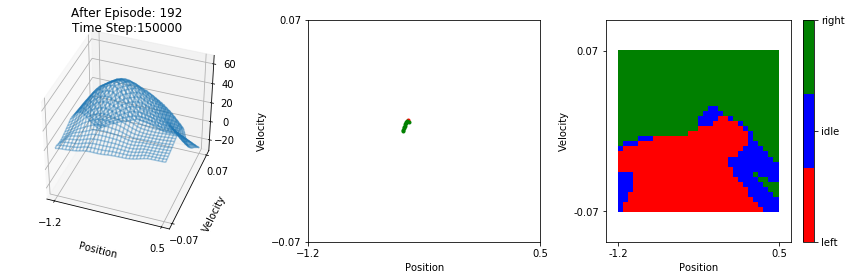

ep, ts, tts 201 8 151000


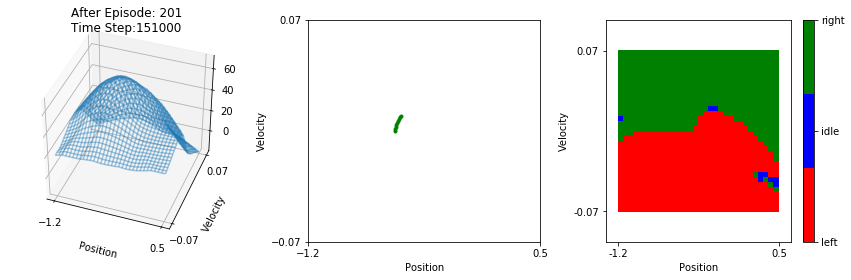

KeyboardInterrupt: 

In [96]:
ts = time.time()
trace_ker_1 = experiment_keras(ep=100000, max_tts=1000000)
#trace_ker_2 = experiment_tiles_batch(ep=30)
#trace_ker_3 = experiment_tiles_batch(ep=30)
print('time', time.time()-ts)

In [ ]:
for ep_nb, q_arr in trace_ker_1.q_values.items():
    print(ep_nb)
    plot_q_max_3d(q_arr, env)


In [58]:
class QFunctKeras():

    def __init__(self, model, st_low, st_high, action_space):
        """Q-function approximator using Keras model

        Args:
            model: Keras compiled model
        """
        self._model = model

        # pdb.set_trace()
    
        first_layer = self._model.layers[0]
        nn_input_shape = first_layer.input_shape[1:]
        if st_low.shape != nn_input_shape:
            raise ValueError('Input shape does not match state_space shape')

        last_layer = self._model.layers[-1]
        nn_output_shape = last_layer.output_shape[1:]
        if action_space.shape != nn_output_shape:
            raise ValueError('Output shape does not match action_space shape')


        # normalise inputs
        self._offsets = st_low + (st_high - st_low) / 2
        self._scales = 1 / ((st_high - st_low) / 2)


    def eval(self, states):
        assert isinstance(states, np.ndarray)
        assert states.ndim == 2

        # pdb.set_trace()
        
#         states = np.copy(states)
#         states -= self._offsets
#         states *= self._scales

        inputs = (states - self._offsets) * self._scales

        return self._model.predict(inputs, batch_size=len(inputs))

        

#     def max_op(self, states):
#         assert isinstance(states, np.ndarray)
        
#         # TODO: use this form and update unittest
#         # inputs = (states - self._offsets) * self._scales
#         inputs = np.copy(states)
#         inputs -= self._offsets
#         inputs *= self._scales
#         outputs = self._model.predict(inputs, batch_size=len(inputs))

#         out_max = np.max(outputs, axis=1)

#         assert out_max.ndim == 1
#         assert len(out_max) == len(states)

#         return out_max

    def train(self, states, actions, targets):
        
        assert isinstance(states, np.ndarray)
        assert isinstance(actions, np.ndarray)
        assert isinstance(targets, np.ndarray)
        assert states.ndim == 2
        assert actions.ndim == 1
        assert targets.ndim == 1
        assert len(states) == len(actions) == len(targets)

        # pdb.set_trace()


        # TODO: use this form and update unittest
        inputs = (states - self._offsets) * self._scales
#         inputs = np.copy(states)
#         inputs -= self._offsets
#         inputs *= self._scales
        all_targets = self._model.predict(inputs, batch_size=len(inputs))
        
        

        # errors = targets - all_targets[np.arange(len(all_targets)), actions]
        all_targets[np.arange(len(all_targets)), actions] = targets
        
        #self._model.train_on_batch(inputs, all_targets)
        self._model.fit(inputs, all_targets, batch_size=len(inputs), epochs=1, verbose=False)

        # return errors

---

# Plot results

In [ ]:
for episode_log in trace_t_s_1.episodes[:3]:
    plot_mountain_car(env, episode_log )

In [ ]:
for episode_log in trace_t_b_1.episodes[:3]:
    plot_mountain_car(env, episode_log )

---

# Appendix - function definitions

In [1]:
def plot_mountain_car(env, episode_log):
    
    q_arr = episode_log.q_values
    states = episode_log.states
    actions = episode_log.actions
    episode = episode_log.episode_nb
    total_tstep = episode_log.total_tstep_finish
    
    fig = plt.figure(figsize=[12,4])

    if q_arr is not None:
        ax = fig.add_subplot(131, projection='3d')
        plot_q_max_3d(q_arr, env, title='After Episode: '+str(episode)+'\nTime Step:'+str(total_tstep), 
                      labels=['Position', 'Velocity', ''], alpha=.4, axis=ax)

    ax = fig.add_subplot(132)
    plot_trajectory(states, actions, env, labels=['Position', 'Velocity'], axis=ax)
    
    ax = fig.add_subplot(133)
    plot_policy(q_arr, env, labels=['Position', 'Velocity'],
                colors=['red', 'blue','green'], collab=['left', 'idle', 'right'], axis=ax)

    plt.tight_layout()
    plt.show()

In [89]:
def plot_mountain_car_2(env, episode, total_tstep, q_arr, states, actions):
    
#     q_arr = episode_log.q_values
#     states = episode_log.states
#     actions = episode_log.actions
#     episode = episode_log.episode_nb
#     total_tstep = episode_log.total_tstep_finish
    
    fig = plt.figure(figsize=[12,4])

    if q_arr is not None:
        ax = fig.add_subplot(131, projection='3d')
        plot_q_max_3d(q_arr, env, title='After Episode: '+str(episode)+'\nTime Step:'+str(total_tstep), 
                      labels=['Position', 'Velocity', ''], alpha=.4, axis=ax)

    ax = fig.add_subplot(132)
    plot_trajectory(states, actions, env, labels=['Position', 'Velocity'], axis=ax)
    
    ax = fig.add_subplot(133)
    plot_policy(q_arr, env, labels=['Position', 'Velocity'],
                colors=['red', 'blue','green'], collab=['left', 'idle', 'right'], axis=ax)

    plt.tight_layout()
    plt.show()

In [2]:
def plot_trajectory(states, actions, env, labels, axis=None):
    if not isinstance(states, np.ndarray): states = np.array(states)
    if not isinstance(actions, np.ndarray): actions = np.array(actions)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
    
    if len(states) == 0:
        axis.scatter(np.array([]), np.array([]))
    else:
        axis.scatter(states[actions==0,0], states[actions==0,1], marker='.', color='red')
        axis.scatter(states[actions==1,0], states[actions==1,1], marker='.', color='blue')
        axis.scatter(states[actions==2,0], states[actions==2,1], marker='.', color='green')
        
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    axis.set_xticks([x_min, x_max])
    #axis.set_xticklabels([x_min,x_max])
    axis.set_yticks([y_min, y_max])
    #axis.set_yticklabels([y_min,y_max])
    
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])

In [3]:
def plot_policy(q_arr, env, labels, colors, collab, axis=None):
    """"""
    q_pol = np.argmax(q_arr, axis=-1)
    
    cmap = ListedColormap(colors)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
        
    heatmap = axis.pcolormesh(q_pol.T, cmap=cmap)
    axis.set_aspect('equal', 'datalim')
    cbar = plt.colorbar(heatmap)
    cbar.set_ticks(range(len(collab)))
    cbar.set_ticklabels(collab)
    
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    axis.set_xticks([0, q_arr.shape[0]])
    axis.set_xticklabels([x_min,x_max])
    axis.set_yticks([0, q_arr.shape[1]])
    axis.set_yticklabels([y_min,y_max])
    
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])

In [4]:
def plot_q_max_3d(q_arr, env, color='#1f77b4', alpha=1.,
                  title='', labels=['x','y','z'], axis=None):
    """Plot 3D wireframe
    
    Params:
        q_arr     - 2d array with dim: [state_x, state_y]
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
        color     - plot color
        alpha     - plot transparency
        labels    - string array [label_x, label_y, label_z], len=3, empty str to omit
        axis      - axis to plot to, if None create new figure
    """
    q_max = -1 * np.max(q_arr, axis=-1)  # calc max and inverse
    
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    x_space = np.linspace(x_min, x_max, num=q_max.shape[0])
    y_space = np.linspace(y_min, y_max, num=q_max.shape[1])
    Y, X = np.meshgrid(y_space, x_space)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111, projection='3d')

    axis.plot_wireframe(X, Y, q_max, color=color, alpha=alpha)
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_zlabel(labels[2])
    axis.set_xticks([x_min, x_max])
    axis.set_yticks([y_min, y_max])
    axis.set_title(title)
    
    axis.view_init(40, -70)

In [60]:
def eval_state_action_space(model, env, split=[32,32]):
    """Evaluate 2d Q-function on area and return as 3d array
    
    Params:
        model     - function approximator with method: model.eval(state, action) -> float
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
                      act_space - action space, e.g. [0, 1, 2]
        split     - number of data points in each dimensions, e.g. [20, 20]
    """
    x_min, x_max = env.state_low[0], env.state_high[0]
    y_min, y_max = env.state_low[1], env.state_high[1]
    x_split, y_split = split
    
    q_arr = np.zeros([x_split, y_split, len(env.act_space)])

    for pi, pos in enumerate(np.linspace(x_min, x_max, x_split)):
        for vi, vel in enumerate(np.linspace(y_min, y_max, y_split)):
            q_values = model.eval(states=np.array([[pos, vel]]))[0]
            for act in env.act_space:
                q_arr[pi, vi, act] = q_values[act]
                
    return q_arr

In [6]:
class Memory:
    """Circular buffer for DQN memory reply. Fairly fast."""

    def __init__(self, max_len, state_shape, state_dtype):
        """
        Args:
            max_len: maximum capacity
        """
        assert isinstance(max_len, int)
        assert max_len > 0

        self._max_len = max_len                            # maximum length        
        self._curr_insert_ptr = 0                          # index to insert next data sample
        self._curr_len = 0                                 # number of currently stored elements

        state_arr_shape = [self._max_len] + list(state_shape)

        self._hist_St = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_At = np.zeros(self._max_len, dtype=int)
        self._hist_Rt_1 = np.zeros(self._max_len, dtype=float)
        self._hist_St_1 = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_done_1 = np.zeros(self._max_len, dtype=bool)

    def append(self, St, At, Rt_1, St_1, done_1):
        """Add one sample to memory, override oldest if max_len reached.

        Args:
            St [np.ndarray]   - state
            At [int]          - action
            Rt_1 [float]      - reward
            St_1 [np.ndarray] - next state
            done_1 [bool]       - next state terminal?
        """
        self._hist_St[self._curr_insert_ptr] = St
        self._hist_At[self._curr_insert_ptr] = At
        self._hist_Rt_1[self._curr_insert_ptr] = Rt_1
        self._hist_St_1[self._curr_insert_ptr] = St_1
        self._hist_done_1[self._curr_insert_ptr] = done_1
        
        if self._curr_len < self._max_len:                 # keep track of current length
            self._curr_len += 1
            
        self._curr_insert_ptr += 1                         # increment insertion pointer
        if self._curr_insert_ptr >= self._max_len:         # roll to zero if needed
            self._curr_insert_ptr = 0

    def __len__(self):
        """Number of samples in memory, 0 <= length <= max_len"""
        return self._curr_len

    def get_batch(self, batch_len):
        """Sample batch of data, with repetition

        Args:
            batch_len: nb of samples to pick

        Returns:
            states, actions, rewards, next_states, next_done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert self._curr_len > 0
        assert batch_len > 0

        # np.random.randint much faster than np.random.sample
        indices = np.random.randint(
            low=0, high=self._curr_len, size=batch_len, dtype=int)

        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)

        return states, actions, rewards_1, states_1, dones_1, indices

    def pick_last_episode(self):
        
        states, actions, rewards_1, states_1, dones_1, indices = self.pick_last(self._curr_len)

        end_of_episode_indices = np.nonzero(dones_1)[0]
        if len(end_of_episode_indices) >= 2:
            current_episode_last_step = end_of_episode_indices[-1]
            previous_episode_last_step = end_of_episode_indices[-2]
        else:
            return np.array([]), np.array([]), np.array([]), \
                   np.array([]), np.array([]), np.array([])
        
        states = states[previous_episode_last_step+1 : current_episode_last_step+1]
        actions = actions[previous_episode_last_step+1 : current_episode_last_step+1]
        rewards_1 = rewards_1[previous_episode_last_step+1 : current_episode_last_step+1]
        states_1 = states_1[previous_episode_last_step+1 : current_episode_last_step+1]
        dones_1 = dones_1[previous_episode_last_step+1 : current_episode_last_step+1]
        indices = indices[previous_episode_last_step+1 : current_episode_last_step+1]
        
        return states, actions, rewards_1, states_1, dones_1, indices
    
    def pick_last(self, nb):
        """Pick last nb elements from memory
        
        Returns:
            states, actions, rewards, next_states, done_1, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert nb <= self._curr_len
        
        start = self._curr_insert_ptr - nb                # inclusive
        end = self._curr_insert_ptr                       # not inclusive
        indices = np.array(range(start,end), dtype=int)   # indices to pick, can be negative
        indices[indices < 0] += self._curr_len            # loop negative to positive
        
        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)
        
        return states, actions, rewards_1, states_1, dones_1, indices
    
    def _print_all(self):
        print()
        print('_hist_St')
        print(self._hist_St)

        print()
        print('_hist_At')
        print(self._hist_At)

        print()
        print('_hist_Rt_1')
        print(self._hist_Rt_1)

        print()
        print('_hist_St_1')
        print(self._hist_St_1)

        print()
        print('_hist_done_1')
        print(self._hist_done_1)

In [7]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, action_space, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low       - state space low boundry, e.g. [-1.2, -0.07] for mountain car
            st_high      - state space high boundry in all dimensions
            action_space - list of possible actions
            learn_rate   - step size, will be adjusted for nb_tilings automatically
            num_tilings  - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val     - initial state-action values
        """
        assert len(st_low) == len(st_high)
        self._n_dim = len(st_low)
        self._act_space = action_space
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)
        
        # e.g. 8 tilings, 2d space, 3 actions
        # nb_total_tiles = (8+1) * (8+1) * 8 * 3
        nb_total_tiles = (num_tilings+1)**self._n_dim * num_tilings * len(action_space)
                
        self._iht = tiles3.IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings
        
    def eval(self, states):
        all_q_values = []
        for state in states:
            assert len(state) == self._n_dim
            scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
            q_values = []
            for action in self._act_space:
                active_tiles = tiles3.tiles(                 # find active tiles
                    self._iht, self._num_tilings,
                    scaled_state, [action])
                q_val = np.sum(self._weights[active_tiles])  # pick correct weights and sum up
                q_values.append(q_val)                       # store result for this action
            all_q_values.append(q_values)
        return np.array(all_q_values)

    def train(self, states, actions, targets):
        assert len(states) == len(actions) == len(targets)
        
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            target = targets[i]
            
            assert len(state) == self._n_dim
            assert np.isscalar(action)
            assert np.isscalar(target)
            
            scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
            active_tiles = tiles3.tiles(                     # find active tiles
                self._iht, self._num_tilings,
                scaled_state, [action])
            value = np.sum(self._weights[active_tiles])      # q-value for state-action pair
            delta = self._lr * (target - value)              # grad is [0,1,0,0,..]
            self._weights[active_tiles] += delta             # ..so we pick active weights instead